In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab02.ipynb")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
%matplotlib inline

# Lab 2: API and Data Cleaning

This lab consists of two parts: the first part will give you more practice with cleaning and manipulating data with pandas, while the second part will shift focus to actually obtaining datasets with API calls. 

### Learning Objectives
- How to make an API call to extract data in the basic settings. 
- How to postprocess the API response and convert the returned data into a dataframe. 
- Filter a dataset for relevant rows and columns. 
- Use groupby and common aggregation techniques. 
- Sort the dataframe by a column. 

----
## Section 1: College Majors
This section is inspired by ["The Economic Guide To Picking A College Major"](https://fivethirtyeight.com/features/the-economic-guide-to-picking-a-college-major/) by FiveThirtyEight. We won't be doing the full length of analysis here.

### Import Data
The dataset is sourced from [Integrated Public Use Microdata Series (IPUMS) USA](https://usa.ipums.org/usa/) for the 2019 ACS and the 2009 ACS.  IPUMS USA collects, preserves and harmonizes U.S. census microdata and provides easy access to these data with enhanced documentation. Data include decennial censuses from 1790 to 2010 and American Community Surveys (ACS) from 2000 to the present. 

In this part of the lab, we will use a fraction (about 6\%) of the data due to Datahub's memory limitation. Feel free to download the entire IPUMS data and play around with it on your local machine. 

First, we will import the data sample. 

In [13]:
ipums_raw = pd.read_csv("data/ipums-acs-sample.csv")
ipums_raw

,YEAR,SAMPLE,SERIAL,CBSERIAL,AGE,SCHOOL,EDUC,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,200901,19,1138,58,1,10,101,62,6203,0,0,1,10,420,40000,40000,40656.0
1,2009,200901,47,3200,56,1,7,71,0,0,0,0,3,30,0,11000,0,0.0
2,2009,200901,81,5508,7,2,1,12,0,0,0,0,0,0,0,9999999,999999,NaN
3,2009,200901,89,5890,13,2,2,23,0,0,0,0,0,0,0,9999999,999999,NaN
4,2009,200901,95,6104,93,1,6,61,0,0,0,0,3,30,0,8100,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2019,201901,1427987,2019001384908,76,1,11,114,23,2306,0,0,3,30,0,126800,0,0.0
199996,2019,201901,1427991,2019001385560,17,2,5,50,0,0,0,0,3,30,0,0,0,0.0
199997,2019,201901,1428005,2019001395346,32,1,6,63,0,0,0,0,1,10,7810,24000,24000,20470.0
199998,2019,201901,1428005,2019001395346,6,2,1,12,0,0,0,0,0,0,0,9999999,999999,NaN


<!-- BEGIN QUESTION -->

**Question 1.1:** We have noticed that there are some missing values in the data (scroll all the way to the right of the dataframe to see some of the NaNs). What are the different ways of handling missing data? What are their advantages? What are their disadvantages?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

**Question 1.2:** For the sake of simplicity, we'll just drop these missing values here, even though it isn't the best approach for dealing with missing data. Fill in the cell below to drop all NaN values.

*Bonus:* Why do we reset index after dropping the missing values?

In [14]:
# drop rows with missing values
ipums_raw = ipums_raw.dropna()
ipums_raw = ipums_raw.reset_index()
ipums_raw.shape[0]

162731

In [15]:
grader.check("q1_2")

q1_2 results: All test cases passed!

### Selecting Relevant Variables

The original dataset contains many variables used to identify a particular household, a person, and their corresponding weights in the sample. We're not interested in those, so we can drop them.

Below are the variables we want to keep in the dataframe. 

| Variable | Label | Description |
| --- | --- | --- |
| YEAR | Census year | YEAR reports the four-digit year when the household was enumerated or included in the census, the ACS, and the PRCS. |
| AGE | Age | AGE reports the person's age in years as of the last birthday. |
| SCHOOL | School attendance | SCHOOL indicates whether the respondent attended school during a specified period. |
| EDUCD | Educational attainment (detailed version) | EDUC indicates respondents' educational attainment, as measured by the highest year of school or degree completed. |
| DEGFIELD | Field of degree (general version) | DEGFIELD reports the field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree. |
| DEGFIELDD | Field of degree (detailed version) | DEGFIELD reports the field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree. |
| DEGFIELD2 | Field of degree (2) (general version) | DEGFIELD2 reports the second field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree in a second field. |
| DEGFIELD2D | Field of degree (2) (detailed version) | DEGFIELD2 reports the second field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree in a second field. |
| EMPSTAT | Employment status (general version) | EMPSTAT indicates whether the respondent was a part of the labor force -- working or seeking work -- and, if so, whether the person was currently unemployed. |
| OCC | Occupation | OCC reports the person's primary occupation, coded into a contemporary census classification scheme |
| INCTOT | Total personal income | INCTOT reports each respondent's total pre-tax personal income or losses from all sources for the previous year. |
| INCWAGE | Wage and salary income | INCWAGE reports each respondent's total pre-tax wage and salary income - that is, money received as an employee - for the previous year.  |
| INCWAGE_CPIU_2010 | Wage and salary income (standardized using CPIU_2010) | INCWAGE reports each respondent's total pre-tax wage and salary income - that is, money received as an employee - for the previous year. |

In [16]:
ipums = ipums_raw[["YEAR", "AGE", "SCHOOL", "EDUCD", "DEGFIELD", 
                   "DEGFIELDD", "DEGFIELD2", "DEGFIELD2D", "EMPSTAT", 
                   "OCC", "INCTOT", "INCWAGE", "INCWAGE_CPIU_2010"
                  ]].copy()
ipums

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
1,2009,56,1,71,0,0,0,0,3,0,11000,0,0.0
2,2009,93,1,61,0,0,0,0,3,0,8100,0,0.0
3,2009,35,1,71,0,0,0,0,3,8140,51000,51000,51837.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162726,2019,58,1,63,0,0,0,0,1,4720,400,400,341.0
162727,2019,76,1,114,23,2306,0,0,3,0,126800,0,0.0
162728,2019,17,2,50,0,0,0,0,3,0,0,0,0.0
162729,2019,32,1,63,0,0,0,0,1,7810,24000,24000,20470.0


### Individuals with College Degrees
Let us explore how different college degrees affect income. To do this, let's first filter the dataset for those individuals who have a college degree (at least a bachelor's degree).  Here's a description of the variables in the `EDUCD` column.

| EDUCD | Description |
| --- | --- |
| ... | ... (rows omitted) |
| 090 | 3 years of college |
| 100 | 4 years of college |
| 101 | Bachelor's degree |
| 110 | 5+ years of college |
| 111 | 6 years of college (6+ in 1960-1970) |
| 112 | 7 years of college |
| 113 | 8+ years of college |
| 114 | Master's degree |
| 115 | Professional degree beyond a bachelor's degree |
| 116 | Doctoral degree |
| 999 | Missing |

Note that records with `EDUCD` greater than or equal to 101 but less than 999 represent a valid record for a person with a college degree. We will use this criterion to filter the dataset. 

**Question 1.3:** Filter the `ipums` dataframe for individuals with a college degree based on the criteria given above. 

In [40]:
ipums_college = ipums[(ipums["EDUCD"] >= 90) & (ipums["EDUCD"] <= 999)]
ipums_college

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
8,2009,72,2,101,23,2300,0,0,3,0,5400,0,0.0
13,2009,38,1,101,62,6201,0,0,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,0,0,3,0,9700,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162719,2019,81,1,101,23,2305,0,0,3,0,45000,0,0.0
162720,2019,36,1,101,62,6200,0,0,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,0,0,1,2310,42000,42000,35823.0
162727,2019,76,1,114,23,2306,0,0,3,0,126800,0,0.0


In [41]:
grader.check("q1_3")

q1_3 results: All test cases passed!

### Individuals in the Workforce

Juniors who cannot work and seniors who have already retired cannot earn wages; therefore we would like to exclude them from our analysis. As per the [OECD norms](https://data.oecd.org/pop/working-age-population.htm), we can assume that working age means 15-64 years old (inclusive). 

**Question 1.4:** Filter the dataframe `ipums_college` for individuals within the working age. 

In [43]:
ipums_college_working_age = ipums_college[(ipums_college["AGE"] >= 15) & (ipums_college["AGE"] <= 64)] 
ipums_college_working_age

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
13,2009,38,1,101,62,6201,0,0,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,0,0,3,0,9700,0,0.0
18,2009,47,1,101,53,5301,0,0,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,11,1103,0,0,3,205,92000,0,0.0
162717,2019,63,1,115,61,6105,0,0,1,3090,12000,12000,10235.0
162720,2019,36,1,101,62,6200,0,0,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,0,0,1,2310,42000,42000,35823.0


In [44]:
grader.check("q1_4")

q1_4 results: All test cases passed!

### Double Majors

Some individuals have double majors. The way the IPUMS ACS dataset captures this is by reporting values in `DEGFIELD2` in addition to `DEGFIELD`. This can complicate our analysis because these individuals' earnings are likely to be affected by both of their majors, while the proportion of influence from each major is unknown. 

**Question 1.5:** To remove this bias from our analysis, we will stick to individuals with only one college major. Filter the dataframe `ipums_college_working_age` to only include students who only have 1 major, and then drop the `DEGFIELD2` and `DEGFIELD2D` columns. Assign your result to `ipums_single_major`.

In [55]:
ipums_single_major = ipums_college_working_age[(ipums_college_working_age["DEGFIELD2"] == 0) & (ipums_college_working_age["DEGFIELD2D"] == 0)]
ipums_single_major = ipums_single_major.drop(columns=['DEGFIELD2', 'DEGFIELD2D'])
ipums_single_major

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,1,4850,50000,50000,50820.0
13,2009,38,1,101,62,6201,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,3,0,9700,0,0.0
18,2009,47,1,101,53,5301,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,11,1103,3,205,92000,0,0.0
162717,2019,63,1,115,61,6105,1,3090,12000,12000,10235.0
162720,2019,36,1,101,62,6200,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,1,2310,42000,42000,35823.0


In [48]:
grader.check("q1_5")

q1_5 results: All test cases passed!

### Interpreting The Majors

Majors in the dataframe (`DEGFIELD`, `DEGFIELDD`) are coded as integers. To find out what each code corresponds to, we will use the conversion dictionaries given below. 

In [49]:
degfield = pd.read_csv("data/degfield.txt", sep='\t').set_index("value").to_dict()["label"]
degfieldd = pd.read_csv("data/degfieldd.txt", sep='\t').set_index("value").to_dict()["label"]
print(degfield)

{0: nan, 11: 'Agriculture', 13: 'Environment and Natural Resources', 14: 'Architecture', 15: 'Area, Ethnic, and Civilization Studies', 19: 'Communications', 20: 'Communication Technologies', 21: 'Computer and Information Sciences', 22: 'Cosmetology Services and Culinary Arts', 23: 'Education Administration and Teaching', 24: 'Engineering', 25: 'Engineering Technologies', 26: 'Linguistics and Foreign Languages', 29: 'Family and Consumer Sciences', 32: 'Law', 33: 'English Language, Literature, and Composition', 34: 'Liberal Arts and Humanities', 35: 'Library Science', 36: 'Biology and Life Sciences', 37: 'Mathematics and Statistics', 38: 'Military Technologies', 40: 'Interdisciplinary and Multi-Disciplinary Studies (General)', 41: 'Physical Fitness, Parks, Recreation, and Leisure', 48: 'Philosophy and Religious Studies', 49: 'Theology and Religious Vocations', 50: 'Physical Sciences', 51: 'Nuclear, Industrial Radiology, and Biological Technologies', 52: 'Psychology', 53: 'Criminal Justic

`DEGFIELD` gives a more general major field. For example, `DEGFIELD` of 55 corresponds to social sciences. 

`DEGFIELDD` gives a more detailed major field. For example, `DEGFIELDD` of 5501 corresponds to Economics. 

Now we will replace all the code in `DEGFIELD` (majors) with texts. 

**Question 1.6:** Replace the values in the `DEGFIELD` and `DEGFIELDD` columns with the corresponding names of the majors.  

Hint: Use [`.replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) and the `to_replace` parameter is a diciontary. 

In [56]:
ipums_single_major['DEGFIELD'] = ipums_single_major["DEGFIELD"].replace(degfield)
ipums_single_major['DEGFIELDD'] = ipums_single_major["DEGFIELDD"].replace(degfieldd)
ipums_single_major

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,Business,Business Management and Administration,1,420,40000,40000,40656.0
4,2009,29,1,101,Business,Marketing and Marketing Research,1,4850,50000,50000,50820.0
13,2009,38,1,101,Business,Accounting,1,800,37000,37000,37607.0
14,2009,64,1,101,Education Administration and Teaching,General Education,3,0,9700,0,0.0
18,2009,47,1,101,Criminal Justice and Fire Protection,Criminal Justice and Fire Protection,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,Agriculture,Animal Sciences,3,205,92000,0,0.0
162717,2019,63,1,115,Medical and Health Sciences and Services,Medical Technologies Technicians,1,3090,12000,12000,10235.0
162720,2019,36,1,101,Business,General Business,1,910,107700,106000,90410.0
162724,2019,39,1,101,Education Administration and Teaching,Elementary Education,1,2310,42000,42000,35823.0


In [57]:
grader.check("q1_6")

q1_6 results: All test cases passed!

----
## Section 2: The Most Lucrative Major

Let's explore which major graduate get the best salary. Have things changed from 2009 to 2019?

### In 2009

Let's take a look at the most lucrative majors as of 2009. 

**Question 2.1:** Filter the `ipums_single_major` dataframe for records for 2009. Then find the median total income (`INCTOT`) and the median wage (`INCWAGE`) for each major (`DEGFIELDD`). Finally, sort the dataframe by the highest median wage. The resulting dataframe should have only three columns: `DEGFIELDD`, `INCTOT`, `INCWAGE` (in that order). Store your results in `ipums_2009_by_major`.

Hint: You may want to use [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) with a correct aggregation function. 

Hint 2: Click [here](https://stackoverflow.com/questions/32751229/pandas-sum-by-groupby-but-exclude-certain-columns) for syntax for calculating specific columns using `.groupby`. 

In [66]:
ipums_2009 = ipums_single_major[ipums_single_major["YEAR"] == 2009]
ipums_2009_by_major = ipums_2009.loc[:,["DEGFIELDD", "INCTOT", "INCWAGE"]] 
ipums_2009_by_major = ipums_2009_by_major.groupby(["DEGFIELDD"]).median().reset_index()
ipums_2009_by_major = ipums_2009_by_major.sort_values(["INCWAGE"], ascending=False)
ipums_2009_by_major

,DEGFIELDD,INCTOT,INCWAGE
1,Actuarial Science,350700.0,356000.0
79,Geosciences,130000.0,130000.0
130,Nuclear Engineering,120015.0,120000.0
137,Petroleum Engineering,110000.0,110000.0
123,Miscellaneous Social Sciences,120000.0,110000.0
...,...,...,...
86,Humanities,10550.0,10550.0
156,Social Psychology,31200.0,10000.0
129,Neuroscience,12800.0,9800.0
149,Precision Production and Industrial Arts,39000.0,4900.0


In [67]:
grader.check("q2_1")

q2_1 results: All test cases passed!

### In 2019

We will repeat the same analysis for 2019.

**Question 2.2:** Create a very similar dataframe as for question 3.1, with the only difference that you're now using data from 2019 instead of 2009. Store your results in `ipums_2019_by_major`.

In [68]:
ipums_2019 = ipums_single_major[ipums_single_major["YEAR"] == 2019]
ipums_2019_by_major = ipums_2019.loc[:,["DEGFIELDD", "INCTOT", "INCWAGE"]] 
ipums_2019_by_major = ipums_2019_by_major.groupby(["DEGFIELDD"]).median().reset_index()
ipums_2019_by_major = ipums_2019_by_major.sort_values(["INCWAGE"], ascending=False)
ipums_2019_by_major

,DEGFIELDD,INCTOT,INCWAGE
129,Naval Architecture and Marine Engineering,181750.0,132500.0
107,Mathematics and Computer Science,130000.0,130000.0
138,Pharmacology,126100.0,125000.0
114,Mining and Mineral Engineering,120000.0,120000.0
104,Materials Science,110000.0,110000.0
...,...,...,...
26,Clinical Psychology,37500.0,20000.0
42,Counseling Psychology,36850.0,20000.0
14,Astronomy and Astrophysics,11000.0,11000.0
54,Electrical and Mechanic Repairs and Technologies,27500.0,5000.0


In [69]:
grader.check("q2_2")

q2_2 results: All test cases passed!

### Comparison

There seems to be a significant change in the most lucrative majors from 2009 to 2019. Let's compare them.

First, we'll select the top ten highest paid majors from 2009 and 2019. We've provided code for that and stored these majors in `top_ten_majors`.

In [70]:
top_ten_majors = list(set(list(ipums_2009_by_major.iloc[:10]["DEGFIELDD"]) + 
                          list(ipums_2019_by_major.iloc[:10]["DEGFIELDD"])
                         ))
top_ten_majors

['Military Technologies',
 'Nuclear Engineering',
 'Mathematics and Computer Science',
 'Materials Engineering and Materials Science',
 'Cognitive Science and Biopsychology',
 'Pharmacy, Pharmaceutical Sciences, and Administration',
 'Electrical Engineering',
 'Materials Science',
 'Applied Mathematics',
 'Atmospheric Sciences and Meteorology',
 'Mining and Mineral Engineering',
 'Petroleum Engineering',
 'Chemical Engineering',
 'Pharmacology',
 'Miscellaneous Social Sciences',
 'Naval Architecture and Marine Engineering',
 'Physical Sciences',
 'Actuarial Science',
 'Aerospace Engineering',
 'Geosciences']

Now, let's filter the table for only these majors. We'll see how they changed from 2009 to 2019.

**Question 2.3:** Filter the `ipums_2019_by_major` and `ipums_2009_by_major` for only the majors in the list `top_ten_majors`, and then merge them together. Finally, sort the dataframe by wages and salaries in 2009 in a descending order. Rename columns `INCTOT` and `INCWAGE` with their corresponding year attached to the end (Ex. For 2019's dataframe, you should rename `INCTOT` to `INCTOT_2019`). 

Hint: You may want to use [`isin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html) ([examples](https://www.geeksforgeeks.org/python-pandas-dataframe-isin/)). 

Hint 2: What parameters should you use while merging? Justify the `how` parameter you choose.

In [90]:
ipums_2019_top_ten_majors = ipums_2019_by_major[ipums_2019_by_major["DEGFIELDD"].isin(top_ten_majors)]
ipums_2019_top_ten_majors = ipums_2019_top_ten_majors.rename(
    columns={"INCTOT": "INCTOT_2019", "INCWAGE": "INCWAGE_2019"}
) # rename the columns
ipums_2009_top_ten_majors = ipums_2009_by_major[ipums_2009_by_major["DEGFIELDD"].isin(top_ten_majors)]
ipums_2009_top_ten_majors = ipums_2009_top_ten_majors.rename(
    columns={"INCTOT": "INCTOT_2009", "INCWAGE": "INCWAGE_2009"} 
) # rename the columns

# merge and sort here
ipums_top_ten_majors = ipums_2009_top_ten_majors.merge(ipums_2019_top_ten_majors, on="DEGFIELDD", how="inner")  
ipums_top_ten_majors = ipums_top_ten_majors.sort_values(["INCWAGE_2009"], ascending=False)
ipums_top_ten_majors

,DEGFIELDD,INCTOT_2009,INCWAGE_2009,INCTOT_2019,INCWAGE_2019
0,Actuarial Science,350700.0,356000.0,3150.0,3150.0
1,Geosciences,130000.0,130000.0,95000.0,95000.0
2,Nuclear Engineering,120015.0,120000.0,81000.0,75000.0
3,Petroleum Engineering,110000.0,110000.0,87700.0,83000.0
4,Miscellaneous Social Sciences,120000.0,110000.0,77500.0,77500.0
5,"Pharmacy, Pharmaceutical Sciences, and Adminis...",98600.0,92000.0,90000.0,80500.0
6,Applied Mathematics,108750.0,92000.0,75000.0,75000.0
7,Physical Sciences,91000.0,90500.0,121000.0,45000.0
8,Atmospheric Sciences and Meteorology,87000.0,87000.0,65000.0,65000.0
9,Mining and Mineral Engineering,81600.0,81500.0,120000.0,120000.0


In [91]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Now, we can visualize the change.

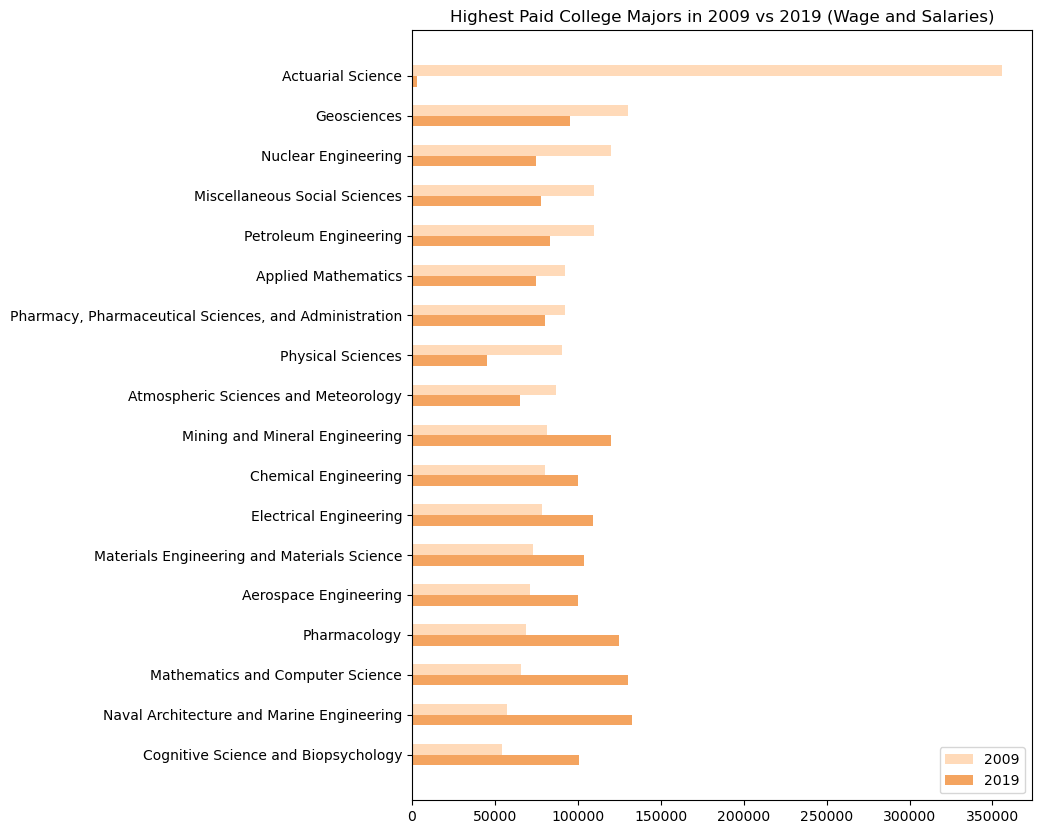

In [92]:
height = 0.8
plt.figure(figsize=(8, 10))

plt.barh(y=np.arange(len(ipums_top_ten_majors))*3+height/2, height=height, 
         width=ipums_top_ten_majors.sort_values("INCWAGE_2009")["INCWAGE_2009"], 
         color="peachpuff", label="2009")

plt.barh(y=np.arange(len(ipums_top_ten_majors))*3-height/2, height=height, 
         width=ipums_top_ten_majors.sort_values("INCWAGE_2009")["INCWAGE_2019"], 
         color="sandybrown", label="2019")

plt.yticks(np.arange(len(ipums_top_ten_majors))*3, ipums_top_ten_majors.sort_values("INCWAGE_2009")["DEGFIELDD"])
plt.title("Highest Paid College Majors in 2009 vs 2019 (Wage and Salaries)")
plt.legend();

<!-- BEGIN QUESTION -->

**Question 2.4:** Comment on the results shown above. Do they match your expectations? Could there be problems with the way this dataset is constructed?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

----
## Section 3: Phillips Curve and FRED API

In this section, we will use an API (Application Programming Interface; more specifically the [FRED API](https://fred.stlouisfed.org/docs/api/fred/)) to obtain Federal Reserve Economic Data and attempt to plot the [Phillip's Curve](https://data88e.org/textbook/content/09-macro/phillips_curve.html). We encourage you to familiarise yourself with the Phillip's Curve if you are not aware of it.

### Step 1: Get the API Key
**In most cases, you will need to obtain an API key in order to access an API.** For many resources, this involves some paperwork to apply and/or limited free usage if you do get it. Also, with certain APIs, people may try to steal your API key to abuse the API (e.g. make too many requests, or try to crash it). Therefore, it is good practice to keep your API keys private.

In this lecture notebook, we will use macroeconomic data from FRED, which is one of the most popular and convenient sources of economic data. For FRED, the process of obtaining an API key is simple. Request the API key [here](https://fred.stlouisfed.org/docs/api/api_key.html). 

**Question 3.1:** Request an API key at [FRED API](https://fred.stlouisfed.org/docs/api/fred/) and paste your API key below. 

Note: For submission, feel free to redact your API key (i.e. replace it with some arbitrary strings); our autograder is configured to not use your API key in testing. It is a good practice not to include your API keys in files that you will share with others. 

In [94]:
api_key = "46b42a03cf4373bfaeaa07eac0703dc2"

In [95]:
grader.check("q3_1")

q3_1 results: All test cases passed!

### Step 2: Read the API's Documentation

Using an API is like ordering food at a restaurant with a menu. For the restaurant to bring you your food, you must know what the restaurant offers and then request specific items from the menu, along with providing additional information on what you're looking for (for example, how would you like your steak). Similarly, you must know what data the API can provide you and then make a specific request to the API, being careful that you're using the right parameters to specify the request. The API documentation tells us about how to use specific commands to get the data that we want, and what the data returned will look like. **Check out the Fred API's documentation [here](https://fred.stlouisfed.org/docs/api/fred/series_observations.html)**. 

<!-- BEGIN QUESTION -->

**Question 3.2:** Identify the parameters and their values you must use if you want to obtain year-over-year real GDP percentage changes (i.e. percent change from year ago values). 

Hint: You can look up the `series_id` of real GDP by searching it on Fred's website. It should be listed in parentheses next to the name of the series. 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Step 3: Make the fetch!
Now we are ready to start writing code to fetch the data we want through the API. 

**Question 3.3:** Complete the function `fetch` so it utilizes the [requests](https://pypi.org/project/requests/) module to return json data given `base_url`, `endpoint` and `params`.

*Hint 1:* See question 4.4 to see what `base_url`, `endpoint` and `params`look like.

*Hint 2:* Python has special strings called **f-strings** that you can use to substitute in values of variables for you into a string. For example:

```python
>>> arr = np.array([1, 2, 3])
>>> print(f"The second element of arr is {arr[1]}")
The second element of arr is 2
```
You may want to use f-strings when you put together the query url in the form of `base_url`, `endpoint`, "?", then `url_params`. 

*Hint 3:* We imported in `urlencode` at the top of the lab, what does it do?


In [96]:
def fetch(base_url, endpoint, params, url_only=False):
    # forms API request
    url_params = urlencode(params)
    url = f"{base_url}{endpoint}?{url_params}"
    
    # For testing purposes only, do not delete
    if url_only:
        return url
    
    # fires off the request
    res = requests.get(url)
    
    # checks if the request encounters an error
    if res.status_code not in range(200, 299):
        raise Exception(f"Fetch request failed (Error: {res.status_code})")
    
    # return the content of the response
    return res.json()

In [97]:
grader.check("q3_3")

q3_3 results: All test cases passed!

**Question 3.4:** We want to get *quarterly* unemployment data (series id: UNRATE) from the first quarter in 1958 (1958-01-01) to the last quarter in 2022 (2022-10-01) via the Fred API. Complete the code below to fetch and construct a dataframe with two columns, `date` and `unrate`. 

Notes: You don't need to sort the data, use the default ordering. If you need to aggregate the data, use the default averaging method.   

Hint: You have to define parameters such as `frequency`, `units`, and `file_type`; reference can be found [here](https://fred.stlouisfed.org/docs/api/fred/series_observations.html). 

In [100]:
base_url = "https://api.stlouisfed.org"
endpoint = "/fred/series/observations"
params_UNRATE = {"series_id":"UNRATE", 
                 "observation_start": "1958-01-01",
                 "observation_end": "2022-10-01",
                 "frequency": "q" ,
                 "units": "lin",
                 "api_key": api_key, 
                 "file_type": "json"
                }

# fetch data
res_json_UNRATE = fetch(base_url, endpoint, params_UNRATE)

# process json data and store it as a dataframe
unemployment = pd.DataFrame(res_json_UNRATE["observations"])[["date", "value"]] # hint: look at what's inside of `res_json_UNRATE`
unemployment.rename(columns={"value": "unrate"}, inplace=True)
unemployment

,date,unrate
0,1958-01-01,6.3
1,1958-04-01,7.4
2,1958-07-01,7.3
3,1958-10-01,6.4
4,1959-01-01,5.8
...,...,...
255,2021-10-01,4.2
256,2022-01-01,3.8
257,2022-04-01,3.6
258,2022-07-01,3.5


In [101]:
grader.check("q3_4")

q3_4 results: All test cases passed!

**Question 3.5:** Now, we want to get the inflation data. This time we will be using *percent change from year ago* core CPI data (series id: CPILFESL) as our inflation measure. Once again, get the quarterly data from the first quarter in 1958 (1958-01-01) to the last quarter in 2022 (2022-10-01) via the Fred API. Complete the code below to fetch and construct a dataframe with two columns, `date` and `inflation`. 

Notes: You don't need to sort the data, use the default ordering. If you need to aggregate the data, use the default averaging method. 

In [104]:
params_INFLATION = {"series_id":"CPILFESL", 
                 "observation_start": "1958-01-01",
                 "observation_end": "2022-10-01",
                 "frequency": "q" ,
                 "units": "pc1",
                 "api_key": api_key, 
                 "file_type": "json"
                }

# fetch data
res_json_INFLATION = fetch(base_url, endpoint, params_INFLATION)

# process json data and store it as a dataframe
inflation = pd.DataFrame(res_json_UNRATE["observations"])[["date", "value"]]
inflation.rename(columns={"value": "inflation"}, inplace=True)
inflation

,date,inflation
0,1958-01-01,6.3
1,1958-04-01,7.4
2,1958-07-01,7.3
3,1958-10-01,6.4
4,1959-01-01,5.8
...,...,...
255,2021-10-01,4.2
256,2022-01-01,3.8
257,2022-04-01,3.6
258,2022-07-01,3.5


In [105]:
grader.check("q3_5")

q3_5 results: All test cases passed!

### Step 4: Plot empirical Phillips curve
And now we can graph our empirical Phillips curve!

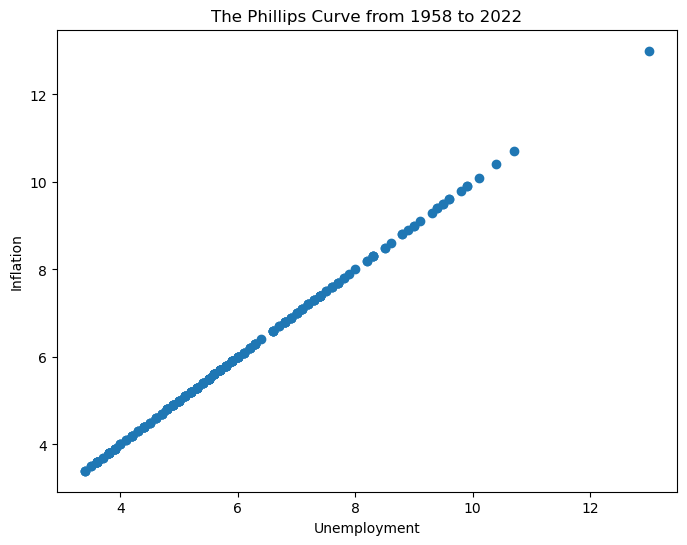

In [106]:
plt.figure(figsize=(8,6))

phillips_curve_df = unemployment.merge(inflation, how="inner", on="date")

phillips_curve_df['unrate'] = phillips_curve_df['unrate'].astype(float)
phillips_curve_df['inflation'] = phillips_curve_df['inflation'].astype(float)

plt.scatter(phillips_curve_df['unrate'], phillips_curve_df['inflation']);
plt.xlabel("Unemployment")
plt.ylabel("Inflation")
plt.title("The Phillips Curve from 1958 to 2022");

----
## (Optional): Income Over Life-Cycle 

In this section of this lab, we will take a look at how lifetime earnings vary by major (this is related to the [Life-Cycle Hypothesis](https://www.economicshelp.org/blog/27080/concepts/life-cycle-hypothesis/). **Although this section is optional, there are no questions you have to answer, and we strongly encourage you to read through it. The results are very cool!** 

For example, some people make a lot of money early in life but don't see a significant increase in income later on; and others don't make a lot of money right out of college, but their income increases significantly as they get older. Let us explore if earnings over time is associated with one's major.

### Economics Majors

First, we will consider economics majors. We define 'economics' to include Agricultural Economics, Economics, and Business Economics, which are represented by the `DEGFIELDD` codes 1102, 5501, and 6205 respectively. Below, we filter the dataframe to consider economics majors using data from 2019.

In [107]:
ipums_2019_econ = ipums_college_working_age[(ipums_college_working_age["DEGFIELDD"].isin([1102, 5501, 6205])) 
& (ipums_college_working_age["YEAR"] == 2019)]
ipums_2019_econ.head()

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
80256,2019,45,1,101,55,5501,0,0,1,120,153000,133000,113439.0
81385,2019,63,1,101,55,5501,0,0,1,9030,32600,30000,25588.0
81581,2019,57,1,101,55,5501,0,0,3,0,0,0,0.0
81690,2019,46,1,101,55,5501,0,0,1,850,80000,80000,68234.0
81785,2019,32,1,115,55,5501,0,0,1,1430,60000,60000,51175.0


Now, let us visualize income over time for economics majors. We will plot the 25th percentile, 50th percentile, 75th percentile, and 90th percentile incomes on the same graph. The y-axis will be the income, and the x-axis will be age.

Below, we have defined the percentile function for you. It can be used as an aggregation function after groupby.

In [108]:
# percentile function used in groupby aggregate
def percentile(n):
    def _percentile(x):
        return np.percentile(x, n)
    _percentile.__name__ = f'percentile_{n}'
    return _percentile

For example, 

```python
>>> df.groupby(...).agg(percentile(25))
```

will return the 25th percentile values in each group. 

Below, we create our plot by grouping by on `AGE`

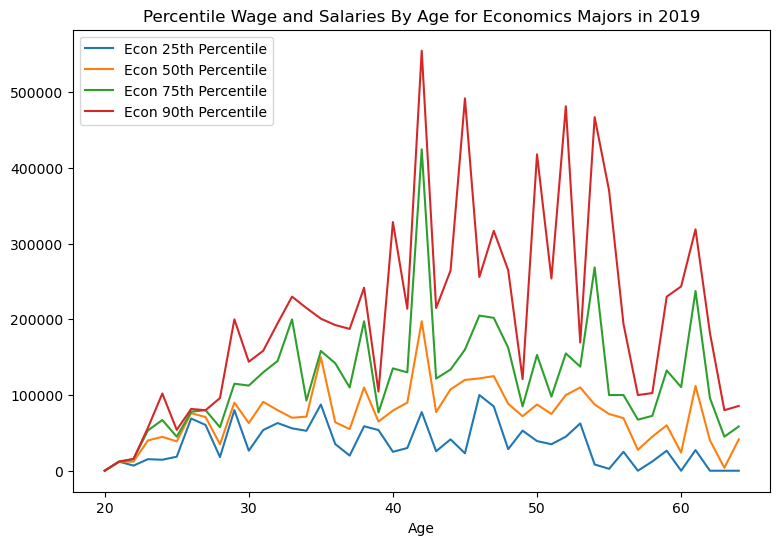

In [109]:
percentiles = [25, 50, 75, 90]
plt.figure(figsize=(9, 6))
for p in percentiles:
    ipums_2019_econ_age = ipums_2019_econ.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    plt.plot("AGE", "INCWAGE", data=ipums_2019_econ_age, label=f"Econ {p}th Percentile")
plt.title("Percentile Wage and Salaries By Age for Economics Majors in 2019")
plt.xlabel("Age")
plt.legend();


*Note that the graph appears to be very volatile. This is due to our small sample size. However, the overall trend is valid.*

### Computer Science Majors

We now repeat the same process for computer science majors, who are represented by the `DEGFIELDD` codes 2100, 2101, 2102, 2106, 2107, 2407, and 4005. 

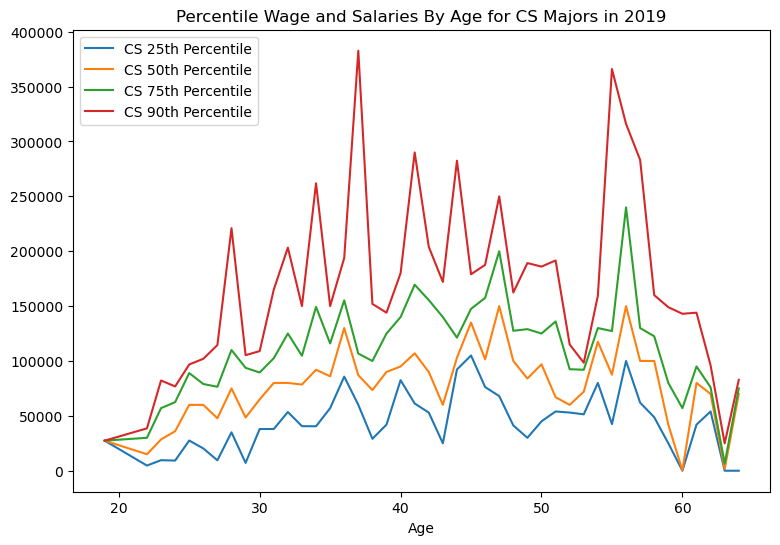

In [110]:
ipums_2019_cs = ipums_college_working_age[
    (ipums_college_working_age["DEGFIELDD"].isin([2100, 2101, 2102, 2106, 2107, 2407, 4005])) 
    & (ipums_college_working_age["YEAR"] == 2019)]

percentiles = [25, 50, 75, 90]
plt.figure(figsize=(9, 6))
for p in percentiles:
    ipums_2019_cs_age = ipums_2019_cs.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    plt.plot("AGE", "INCWAGE", data=ipums_2019_cs_age, label=f"CS {p}th Percentile")
plt.title("Percentile Wage and Salaries By Age for CS Majors in 2019")
plt.xlabel("Age")
plt.legend();

### Comparison

Let's now compare the income over time for economics vs computer science majors. Below, we plot them on top of each other.

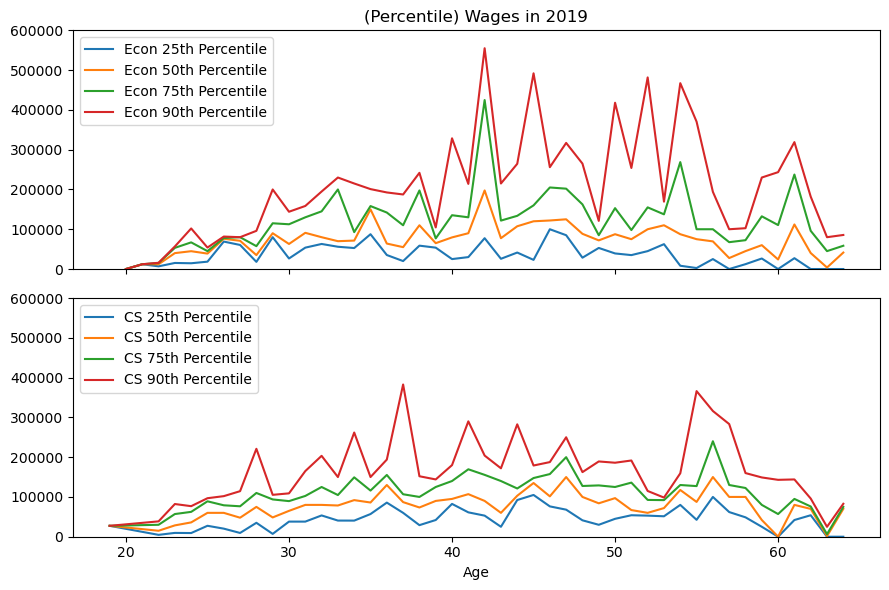

In [111]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 6));
percentiles = [25, 50, 75, 90]

for p in percentiles:
    ipums_2019_econ_age = ipums_2019_econ.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    ax1.plot("AGE", "INCWAGE", data=ipums_2019_econ_age, label=f"Econ {p}th Percentile");
    ipums_2019_cs_age = ipums_2019_cs.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    ax2.plot("AGE", "INCWAGE", data=ipums_2019_cs_age, label=f"CS {p}th Percentile");

ax1.set_ylim(0, 600000)
ax1.set_title("(Percentile) Wages in 2019")
ax1.legend();

ax2.set_ylim(0, 600000)
ax2.set_xlabel("Age")
ax2.legend();

plt.tight_layout();
plt.show();


We can also plot them on the same axis if you like, although this plot suffers from [overplotting](https://www.displayr.com/what-is-overplotting/).

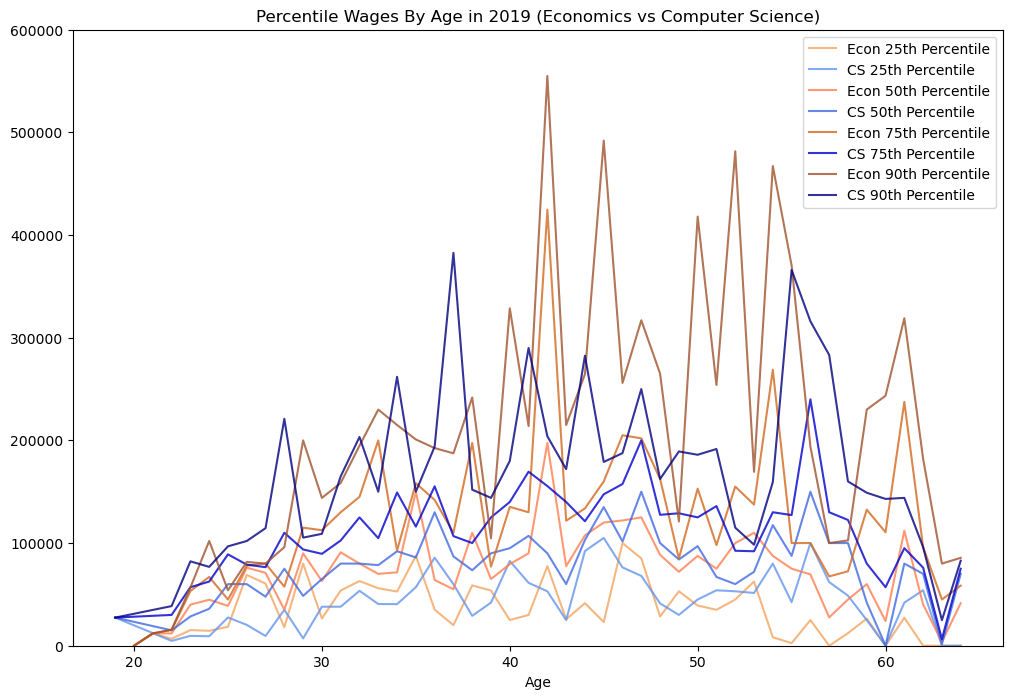

In [112]:
colors = ['sandybrown', 'coral', 'chocolate', 'sienna', 'cornflowerblue', 'royalblue', 'mediumblue', 'navy']
plt.figure(figsize=(12, 8))

percentiles = [25, 50, 75, 90]

for i, p in enumerate(percentiles):
    ipums_2019_econ_age = ipums_2019_econ.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    plt.plot("AGE", "INCWAGE", data=ipums_2019_econ_age, label=f"Econ {p}th Percentile", color=colors[i],alpha=0.8)
    ipums_2019_cs_age = ipums_2019_cs.groupby("AGE")[["INCTOT", "INCWAGE"]].agg(percentile(p)).reset_index()
    plt.plot("AGE", "INCWAGE", data=ipums_2019_cs_age, label=f"CS {p}th Percentile", color=colors[i+len(percentiles)],alpha=0.8)

plt.ylim(0, 600000)
plt.title("Percentile Wages By Age in 2019 (Economics vs Computer Science)")
plt.xlabel("Age")
plt.legend();

Feel free to repeat the analysis by looking at total income rather than total wage if you like, you have all the data necessary.

Does the curve above match what you would expect? Look [here](https://academic.oup.com/qje/article/137/3/1299/6529257) for a more advanced analysis of the Phillip's Curve, coauthored by John Bates Clark Medal Winner and UC Berkeley Economics Professor Emi Nakamura.

**Congratulations!** You're done with Econ 148 Lab 2!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)